In [1]:
import torch 
from torch.utils.data import  DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn as nn
from torchsummary import summary

In [9]:
# Hyperparameters
batch_size = 32
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eyes_input = (64,64)
face_input = (256,256)

In [3]:
def get_transformer(input_size):
    return transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

In [4]:
directory = 'data'
eyes_transformer = get_transformer(eyes_input)
face_transformer = get_transformer(face_input)
eyes_trainset = datasets.ImageFolder(root='data/train/eyes', transform=eyes_transformer)
eyes_testset = datasets.ImageFolder(root='data/test/eyes', transform=eyes_transformer)
face_trainset = datasets.ImageFolder(root='data/train/face', transform=face_transformer)
face_testset = datasets.ImageFolder(root='data/test/face', transform=face_transformer)
# Data length 
print('Eyes Train:', len(eyes_trainset))
print('Eyes Test:', len(eyes_testset))
print('Face Train:', len(face_trainset))
print('Face Test:', len(face_testset))

# Data classes
print('Eyes Classes:', eyes_trainset.classes)
print('Face Classes:', face_trainset.classes)



Eyes Train: 1234
Eyes Test: 218
Face Train: 1233
Face Test: 215
Eyes Classes: ['Closed', 'Open']
Face Classes: ['no_yawn', 'yawn']


In [5]:
# Data loaders
eyes_trainloader = DataLoader(eyes_trainset, batch_size=batch_size, shuffle=True)
eyes_testloader = DataLoader(eyes_testset, batch_size=batch_size, shuffle=True)
face_trainloader = DataLoader(face_trainset, batch_size=batch_size, shuffle=True)
face_testloader = DataLoader(face_testset, batch_size=batch_size, shuffle=True)
# Data loaders length
print('Eyes Train Loader:', len(eyes_trainloader))
print('Eyes Test Loader:', len(eyes_testloader))
print('Face Train Loader:', len(face_trainloader))
print('Face Test Loader:', len(face_testloader))



Eyes Train Loader: 39
Eyes Test Loader: 7
Face Train Loader: 39
Face Test Loader: 7


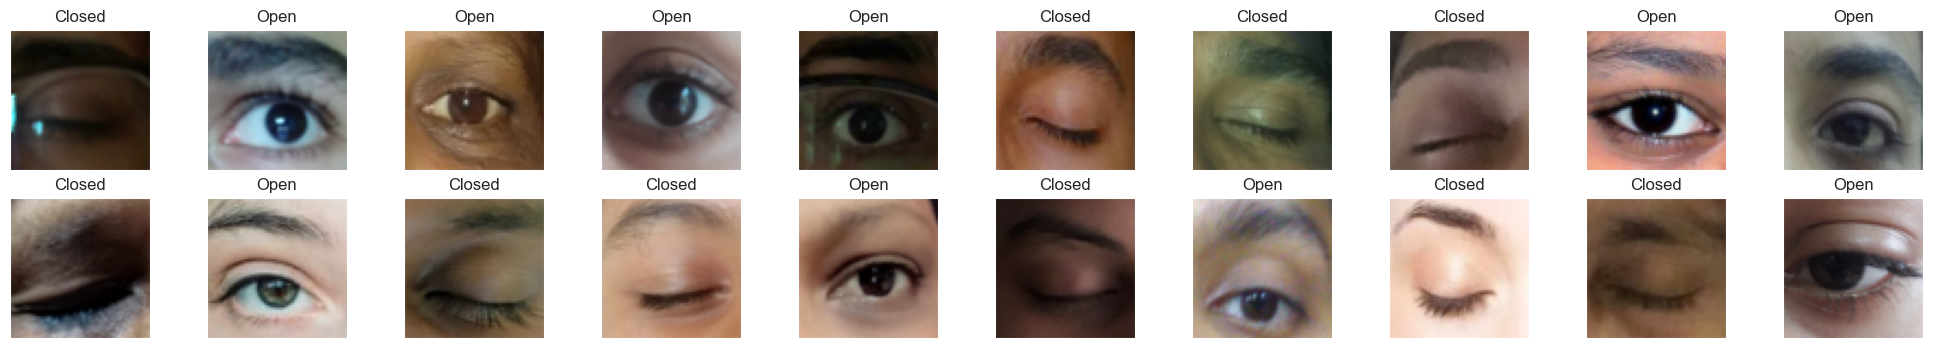

In [6]:
# Displaying images from each dataset for each class
import matplotlib.pyplot as plt
import numpy as np
def show_images(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images.numpy()
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])
show_images(eyes_trainloader, eyes_trainset.classes)



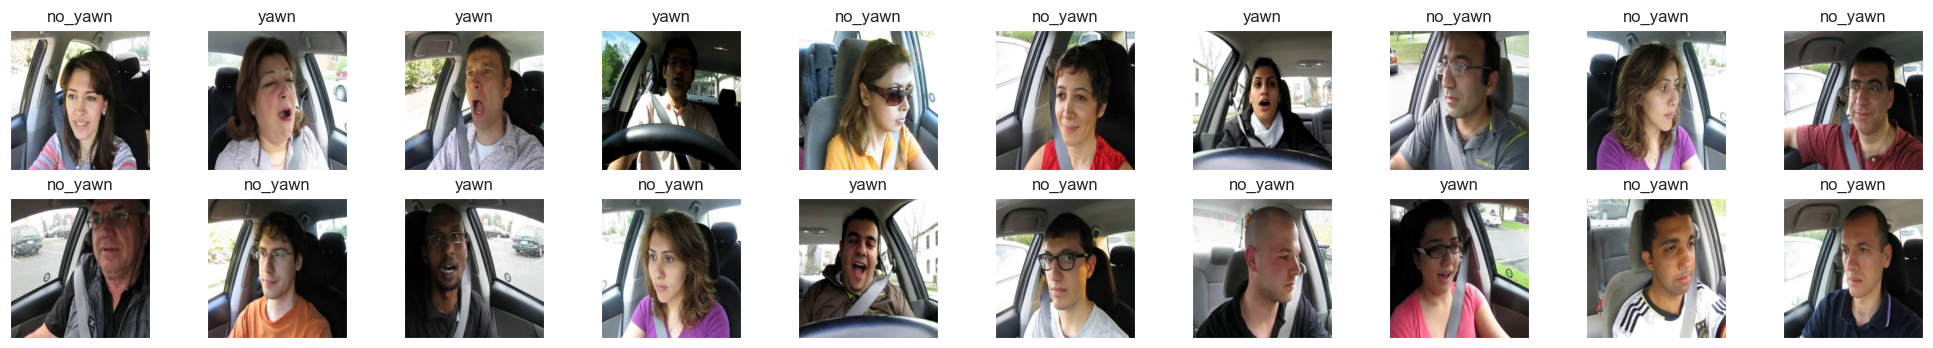

In [7]:
show_images(face_trainloader, face_trainset.classes)

In [8]:
# define a function for Xavier initialization
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
criterion = nn.CrossEntropyLoss()

In [37]:
# Model for eyes dataset 
class EyesModel(nn.Module):
    def __init__(self):
        super(EyesModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [39]:
# loss function and optimizer for eyes model
learning_rate_eye = 0.002
eyes_model = EyesModel()
eyes_model.apply(init_weights)
eyes_model.to(device)
eyes_model_optimizer = torch.optim.Adam(eyes_model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# Summary of the model
summary(eyes_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
           Dropout-7                 [-1, 8192]               0
            Linear-8                  [-1, 512]       4,194,816
           Dropout-9                  [-1, 512]               0
           Linear-10                    [-1, 2]           1,026
Total params: 4,289,090
Trainable params: 4,289,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.26
Params size (MB): 16.36
Estima

In [40]:
# Training loop (not a function) for eyes model with metrics
def train_eyes_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss/len(train_loader))
        train_accuracy.append(100 * correct / total)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(running_loss/len(test_loader))
        test_accuracy.append(100 * correct / total)
        # print both train and test metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.2f}%')
        
    return train_losses, test_losses, train_accuracy, test_accuracy



In [41]:
# Training the eyes model
eyes_train_losses, eyes_test_losses, eyes_train_accuracy, eyes_test_accuracy = train_eyes_model(eyes_model, eyes_trainloader, eyes_testloader, criterion, eye_model_optimizer, num_epochs)

Epoch 1/10, Train Loss: 0.6081, Train Accuracy: 71.39%, Test Loss: 0.4379, Test Accuracy: 87.16%
Epoch 2/10, Train Loss: 0.3025, Train Accuracy: 90.92%, Test Loss: 0.1826, Test Accuracy: 94.95%
Epoch 3/10, Train Loss: 0.1628, Train Accuracy: 94.57%, Test Loss: 0.1211, Test Accuracy: 96.33%
Epoch 4/10, Train Loss: 0.1135, Train Accuracy: 96.52%, Test Loss: 0.1060, Test Accuracy: 96.33%
Epoch 5/10, Train Loss: 0.0914, Train Accuracy: 96.43%, Test Loss: 0.1150, Test Accuracy: 96.79%
Epoch 6/10, Train Loss: 0.0886, Train Accuracy: 96.60%, Test Loss: 0.1020, Test Accuracy: 97.25%
Epoch 7/10, Train Loss: 0.0657, Train Accuracy: 97.41%, Test Loss: 0.0845, Test Accuracy: 96.79%
Epoch 8/10, Train Loss: 0.0602, Train Accuracy: 97.73%, Test Loss: 0.0825, Test Accuracy: 97.25%
Epoch 9/10, Train Loss: 0.0528, Train Accuracy: 97.89%, Test Loss: 0.0899, Test Accuracy: 96.33%
Epoch 10/10, Train Loss: 0.0477, Train Accuracy: 98.46%, Test Loss: 0.0849, Test Accuracy: 96.79%


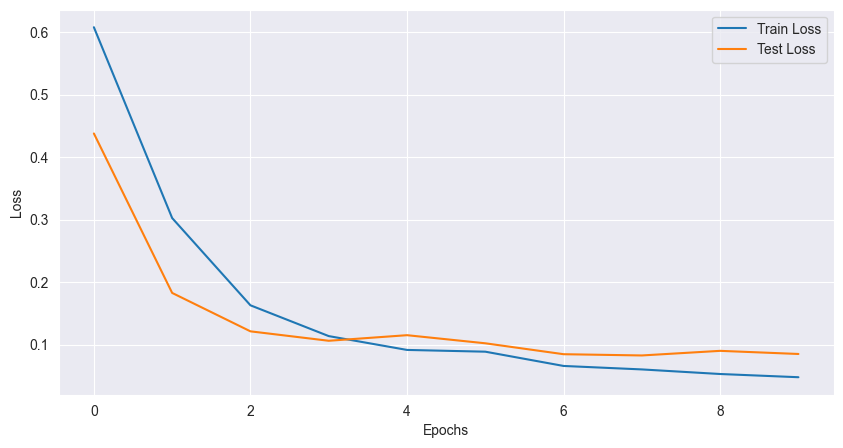

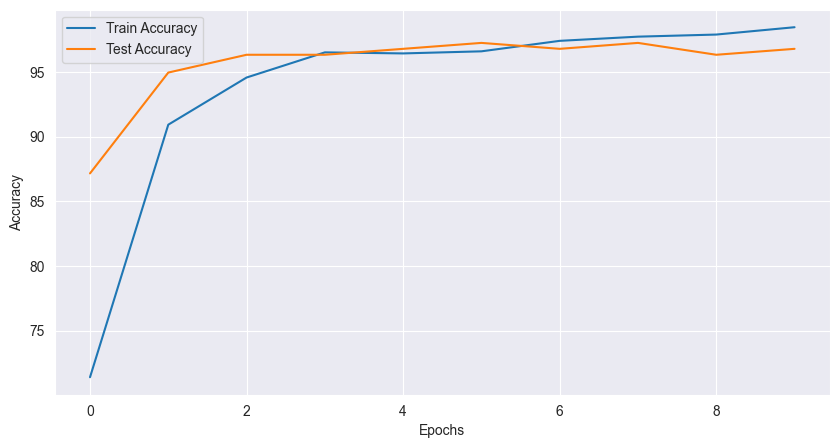

In [42]:
# Learning curves for eyes model in one plot for accuracy and loss
plt.figure(figsize=(10, 5))
plt.plot(eyes_train_losses, label='Train Loss')
plt.plot(eyes_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(eyes_train_accuracy, label='Train Accuracy')
plt.plot(eyes_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [19]:
# Dispaly confusion matrix with test data for eyes model 
from sklearn.metrics import confusion_matrix
import seaborn as sns
def display_confusion_matrix(model, test_loader,testset):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
display_confusion_matrix(eyes_model, eyes_testloader)

In [46]:
# Save eyes model
torch.save(eyes_model.state_dict(), 'models/eyes_model.pth')

In [11]:
# Model for face dataset
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*16*16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x): # input size (3, 256, 256)
        x = self.pool(nn.functional.relu(self.conv1(x))) # output size (64, 128, 128)
        x = self.pool(nn.functional.relu(self.conv2(x))) # output size (128, 64, 64)
        x = self.pool(nn.functional.relu(self.conv3(x))) # output size (512, 32, 32)
        x = self.pool(nn.functional.relu(self.conv4(x))) # output size (512, 16, 16)
        x = x.view(-1, 256 * 16 * 16 )
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# loss function and optimizer for face model
face_model = FaceModel()
face_model.apply(init_weights)
face_model.to(device)
learning_rate_face = 0.002
face_model_optimizer = torch.optim.Adam(face_model.parameters(), lr=learning_rate_face,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# Summary of the model
summary(face_model, (3, 256, 256))

In [12]:


# Training loop  for face model with metrics
def train_face_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss/len(train_loader))
        train_accuracy.append(100 * correct / total)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(running_loss/len(test_loader))
        test_accuracy.append(100 * correct / total)
        # print both train and test metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.2f}%')
        
    return train_losses, test_losses, train_accuracy, test_accuracy

# Training the face model
face_train_losses, face_test_losses, face_train_accuracy, face_test_accuracy = train_face_model(face_model, face_trainloader, face_testloader, criterion, face_model_optimizer, num_epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
         MaxPool2d-8          [-1, 256, 16, 16]               0
           Dropout-9                [-1, 65536]               0
           Linear-10                  [-1, 512]      33,554,944
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 33,944,386
Trainable params: 33,944,386
Non-trainable params: 0
-------------------------

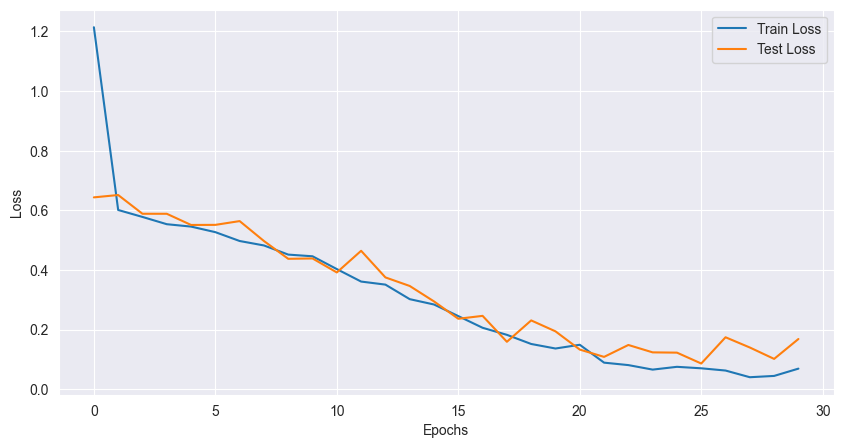

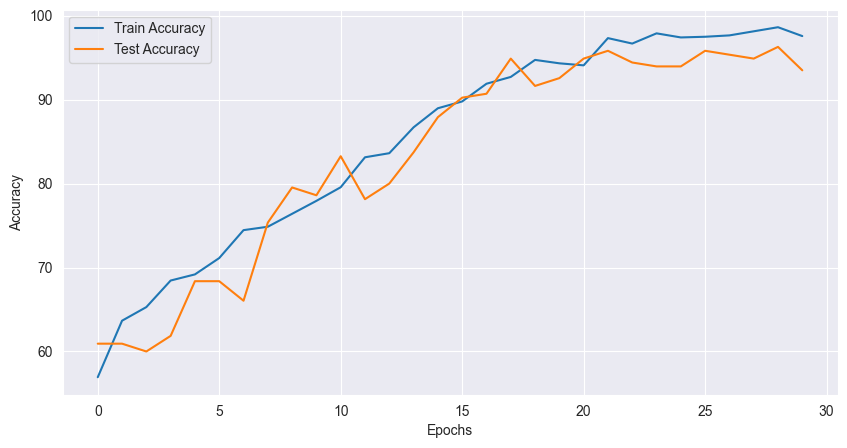

In [13]:
# Learning curves for face model in one plot for accuracy and loss
plt.figure(figsize=(10, 5))
plt.plot(face_train_losses, label='Train Loss')
plt.plot(face_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(face_train_accuracy, label='Train Accuracy')
plt.plot(face_test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


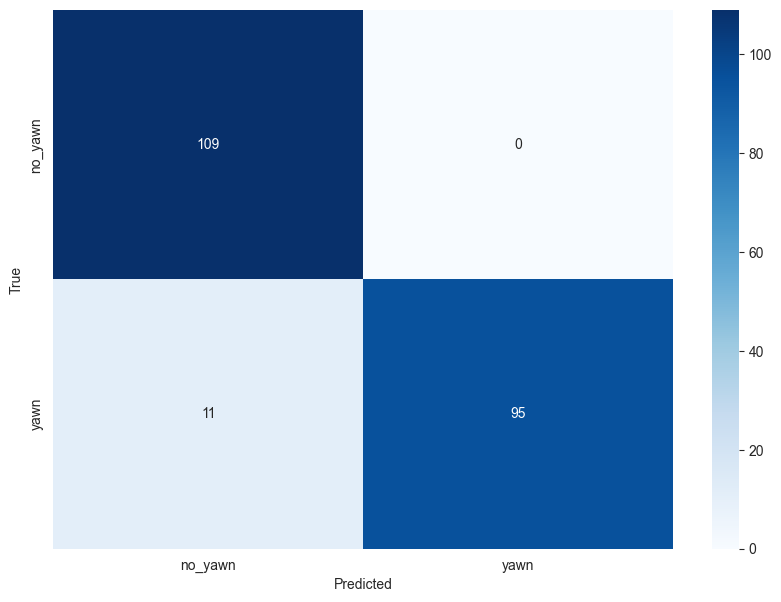

In [20]:
# Dispaly confusion matrix with test data for face model
display_confusion_matrix(face_model, face_testloader,face_testset)

In [21]:
# print table with precision, recall and f1-score for face model
from sklearn.metrics import classification_report
def display_classification_report(model, test_loader, testset):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()
    print(classification_report(y_true, y_pred, target_names=testset.classes))
display_classification_report(face_model, face_testloader, face_testset)

              precision    recall  f1-score   support

     no_yawn       0.91      0.99      0.95       109
        yawn       0.99      0.90      0.94       106

    accuracy                           0.94       215
   macro avg       0.95      0.94      0.94       215
weighted avg       0.95      0.94      0.94       215


In [15]:
# Save face model
torch.save(face_model.state_dict(), 'models/face_model.pth')

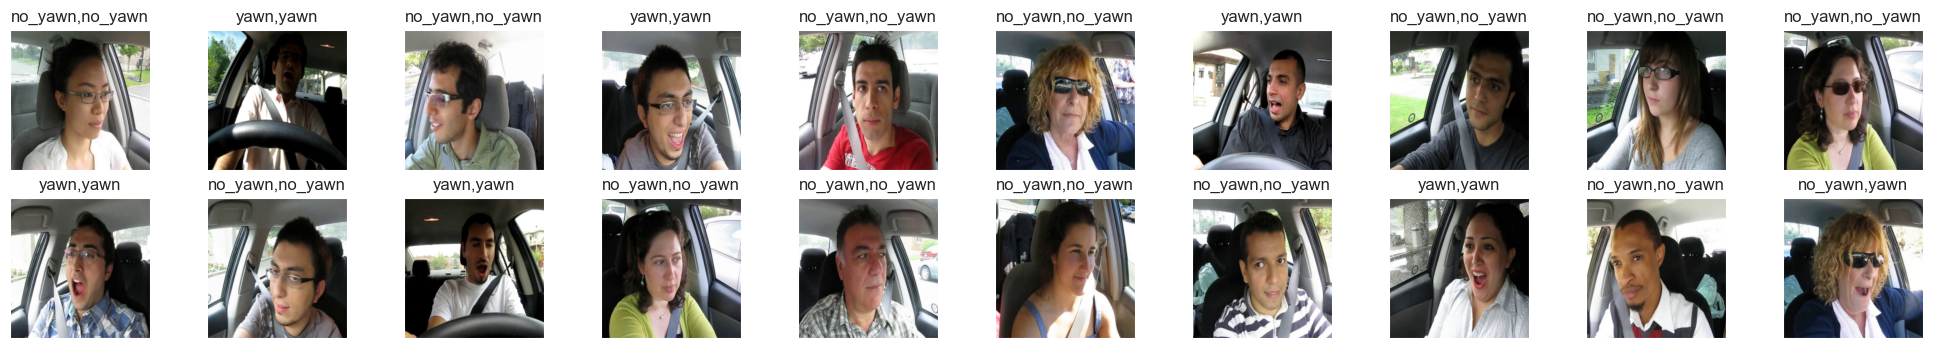

In [16]:
# test the model with a test image from testset
def test_model(model, test_loader):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    images = images.cpu().numpy()
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(f'{face_testset.classes[predicted[idx]]},{face_testset.classes[labels[idx]]}')
        
# test the face model
test_model(face_model, face_testloader)